<a href="https://colab.research.google.com/github/yoonwanggyu/Alpaco_Project/blob/main/%EA%B0%9D%EC%B2%B4%EC%9D%B8%EC%8B%9D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8(06.03~06.20)/%EB%B2%BC_%EC%83%9D%EC%9C%A1%EC%9D%B4%EC%83%81_SegFormer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 농경 자율주행 Segformer

## Inference

In [1]:
!pip install -q transformers # is already installed in Google Colab

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 4114, in parseImpl
    return e._parse(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 821, in _parseNoCache
    loc, tokens = self.parseImpl(instring, pre_loc, doActions)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 2341, in parseImpl
    raise ParseException(instring, loc, self.errmsg, self)
pip._vendor.pyparsing.exceptions.ParseException: Expected 'platform.machi

In [2]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
# we are going to do whole inference, so no resizing of the image
processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)

KeyboardInterrupt: 

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image
import matplotlib.pyplot as plt

# load image + ground truth map
# repo_id = "hf-internal-testing/fixtures_ade20k"
image_path = "/content/drive/MyDrive/RGB/NIA_AgricultureAD_field_RGB_top_Gyeongsangnamdo_2110211031_day_sunny_000009.jpg"
image = Image.open(image_path)
# segmentation_map_path = hf_hub_download(repo_id=repo_id, filename="ADE_val_00000001.png", repo_type="dataset")
# segmentation_map = Image.open(segmentation_map_path)
plt.imshow(image)

In [ ]:
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

In [ ]:
print(pixel_values.shape)

In [ ]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [ ]:
print(logits.shape)

In [ ]:
# model_mapper = {
#     'segformer-b0': 'nvidia/segformer-b0-finetuned-cityscapes-768-768',
#     'segformer-b5': 'nvidia/segformer-b5-finetuned-cityscapes-1024-1024'
# }
# cityscapes_classes = [
#     "road",
#     "sidewalk",
#     "building",
#     "wall",
#     "fence",
#     "pole",
#     "traffic light",
#     "traffic sign",
#     "vegetation",
#     "terrain",
#     "sky",
#     "person",
#     "rider",
#     "car",
#     "truck",
#     "bus",
#     "train",
#     "motorcycle",
#     "bicycle",
# ]
cityscapes_palette = [
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30]
]

In [ ]:
predicted_segmentation_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(cityscapes_palette)
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

# 벼 생육이상 판별 SegFormer

## json2mask

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
!unzip -qq '/content/drive/MyDrive/GNE_cv2_merge.zip' -d '/content/'

In [ ]:
!unzip -qq '/content/drive/MyDrive/labels_G.zip' -d '/content/'

In [ ]:
import json
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os
import torch
import torchvision.transforms as T
from skimage.draw import polygon2mask
import cv2
import time

class CustomDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms

        # 클래스 ID 및 레이블 매핑 정의
        self.id2label = {
            0: '00',    # background
            1: '01',
            2: '02',
            3: '03',
            4: '04',
            5: '05',
        }

        self.label2id = {v: k for k, v in self.id2label.items()}  # 레이블을 ID로 매핑

        self.label_list = os.listdir(self.ann_dir) # json 파일 리스트
        self.img_paths = []
        self.ann_paths = []

        #start_time = time.time()
        # 미리 경로 계산
        for label in self.label_list:
            with open(os.path.join(self.ann_dir, label), 'r', encoding='utf-8') as f:
                img_info = json.load(f)
            img_file_id = img_info['IMAGES'].get('IMAGE_FILE_ID')
            if not img_file_id.endswith('.'):
                img_file_id += '.'
            img_path = os.path.join(self.img_dir, f"{img_file_id}png")
            self.img_paths.append(img_path)
            self.ann_paths.append(os.path.join(self.ann_dir, label))
        #print(f"Data paths loaded in {time.time() - start_time:.2f} seconds")

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        ann_path = self.ann_paths[idx]

       # start_time = time.time()
        #print(ann_path)
        with open(ann_path, 'r', encoding='utf-8') as f:
            img_info = json.load(f)
        #print(f"Annotation loaded in {time.time() - start_time:.2f} seconds")

        #start_time = time.time()
        image = Image.open(img_path)
        #print(f"Image loaded in {time.time() - start_time:.2f} seconds")

        mask = np.full((image.height, image.width), 0, dtype=np.int32)  # 초기값을 0으로 설정

        #start_time = time.time()
        for obj in img_info['ANNOTATIONS']:
            class_id = self.get_class_index(obj['OBJECT_CLASS_CODE'])
            x_coords = obj['PYN_XCRDNT']
            y_coords = obj['PYN_YCRDNT']

            # x_coords와 y_coords가 비어 있는 경우 건너뜀
            if not x_coords or not y_coords:
               # print("Empty coordinates, skipping object.")
               continue

            coords = [(y,x) for x, y in zip(x_coords, y_coords)]
            #print(len(coords))

            #      # 좌표가 이미지 경계를 벗어나는지 확인
            out_of_bounds_coords = [(x, y) for y, x in coords if x < 0 or x >= image.width or y < 0 or y >= image.height]
            if out_of_bounds_coords:
                    #print(f"Warning: Some coordinates for {obj['label']} are out of image bounds: {out_of_bounds_coords}")
                coords = [(max(0, min(image.height - 0.1, y)), max(0, min(image.width - 0.1, x))) for y, x in coords] # 이미지 벗어나는 좌표 클리핑

            # 좌표가 이미지 경계를 벗어나는지 확인 및 클리핑
            # coords = [(max(0, min(image.height - 1, y)), max(0, min(image.width - 1, x))) for y, x in coords]


            poly_mask = polygon2mask((image.height, image.width), coords)

                # 디버깅용으로 poly_mask가 True인 위치 출력
                # true_indices = np.where(poly_mask)
                # true_positions = list(zip(true_indices[0], true_indices[1]))
                # print(f"True positions in poly_mask: {true_positions[:10]}")  # 처음 10개의 위치만 출력

            mask[poly_mask] = class_id
        #print(f"Masks created in {time.time() - start_time:.2f} seconds")
                # # 개별 마스크 시각화(디버깅)
                # plt.figure(figsize=(6, 6))
                # plt.imshow(mask, cmap='gray')
                # plt.title(f"{obj['label']} with class ID {class_id}")
                # plt.show()

        if self.transforms:
            image = self.transforms(image)

        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

    def get_class_index(self, label):
        return self.label2id.get(label, 0)  # 기본값 0 (배경)

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2


### Data augmentation을 고려할 필요가 있음

transforms = T.Compose([
    T.ToTensor()
])

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

In [ ]:
# 데이터셋 경로 설정
img_dir = "/content/GNE_cv2_merge"
ann_dir = "/content/labels_G"

# 전체 데이터셋 로드
dataset = CustomDataset(img_dir, ann_dir,transforms = transforms)
print(len(dataset))

31955


In [ ]:
# 데이터셋 인덱스 생성 및 섞기
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)

# 데이터셋을 학습용과 검증용으로 분할
split = int(len(indices) * 0.8)
train_indices = indices[:split]
val_indices = indices[split:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
print(len(train_dataset))
print(len(val_dataset))

# small_train_dataset = torch.utils.data.Subset(train_dataset, range(10))
# small_valid_dataset= torch.utils.data.Subset(val_dataset, range(10))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

25564
6391


## Wandb

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# wandb 초기화
wandb.init(project="rice", id="first_result")
# wandb.config.update({
#     "epochs": num_epochs,
#     "batch_size": 16,
#     "start_epoch": start_epoch,
#     "learning_rate": 0.00006,
# })

wandb: Currently logged in as: wanggyu3467 (wanggyu). Use `wandb login --relogin` to force relogin


## 모델 초기화

In [ ]:
from transformers import SegformerForSemanticSegmentation
from torch.cuda.amp import GradScaler

# 모델 초기화
model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
# 클래스 ID 및 레이블 매핑 정의
id2label = {
            0: '00',    # background
            1: '01',
            2: '02',
            3: '03',
            4: '04',
            5: '05',
        }
# 반대 매핑 생성
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)  # 데이터셋의 클래스 수에 맞게 설정
MODEL_CHECKPOINT = 'nvidia/mit-b3'

model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=len(id2label),  # 클래스 수 지정
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 사전 훈련된 모델과 크기 불일치 무시
)

# 모델을 GPU 또는 CPU 장치로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 옵티마이저 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

# AMP를 위한 스케일러 설정
scaler = GradScaler()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/189M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([6, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_metric
import evaluate  # evaluate 라이브러리를 사용합니다

import os

# 저장할 폴더 지정 및 생성
model_save_path = "saved_models"
model_filename = "best_model.pth"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
full_model_path = os.path.join(model_save_path, model_filename)

start_epoch = 0  # 시작 에폭 설정
num_epochs = 10  # 총 학습 에폭 설정



# 설정 변수
gradient_accumulation_steps = 4
best_mean_iou = 0.0

iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # evaluate 라이브러리를 사용하여 메트릭 로드

# validation
def validate_amp(model, val_loader, device, scaler, num_labels=6, ignore_index=255):
    model.eval()  # 모델을 평가 모드로 전환
    total_loss = 0
    total_correct = 0
    total_pixels = 0
    iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # 각 검증 루프마다 메트릭을 새로 초기화

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader), desc="Validating", unit="batch")  # tqdm을 사용하여 검증 진행 상황 표시
        for batch in val_loader:
            pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
            labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동

            with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits  # 로짓 값
                upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)  # 로짓을 라벨 크기로 보간
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)  # 교차 엔트로피 손실 계산

            total_loss += loss.item()  # 총 손실 계산
            predicted = upsampled_logits.argmax(dim=1)  # 예측값 계산

             # Pixel accuracy 계산
            correct = (predicted == labels).sum().item()
            total = (labels != ignore_index).sum().item()
            total_correct += correct
            total_pixels += total

            iou_metric.add_batch(predictions=predicted, references=labels)  # 메트릭에 배치 추가
            pbar.update(1)

        pbar.close()

    avg_loss = total_loss / len(val_loader)  # 평균 손실 계산
    mean_iou = iou_metric.compute(num_labels=num_labels, ignore_index=ignore_index)  # Mean IoU 계산
    pixel_accuracy = total_correct / total_pixels  # Pixel Accuracy 계산
    return avg_loss, mean_iou, pixel_accuracy  # 평균 손실과 Mean IoU 반환

## 모델 돌리기

In [ ]:
# 훈련 및 검증 루프
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/10", unit="batch")  # tqdm을 사용하여 훈련 진행 상황 표시
    for idx, batch in enumerate(train_loader):
        images, masks = batch
        # print(f"Batch {idx} - Images Shape: {images.shape}, Masks Shape: {masks.shape}")
        # print(f"Images dtype: {images.dtype}, Masks dtype: {masks.dtype}")
        # print(f"Images min: {images.min()}, max: {images.max()}")
        # print(f"Masks unique values: {torch.unique(masks)}")
        pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
        labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동

        optimizer.zero_grad(set_to_none=True)  # 옵티마이저의 기울기 초기화

        with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps

        scaler.scale(loss).backward()  # 스케일된 손실에 대한 역전파

        if (idx + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)  # 스케일된 파라미터로 옵티마이저 스텝
            scaler.update()  # 스케일러 업데이트
            optimizer.zero_grad()  # 옵티마이저의 기울기 초기화

        train_loss += loss.item() * gradient_accumulation_steps  # 총 훈련 손실 계산
        pbar.update(1)
        pbar.set_postfix(batch_loss=f"{loss.item():.4f}")

    pbar.close()
    val_loss, mean_iou, pixel_accuracy = validate_amp(model, val_loader, device, scaler)  # 검증 함수 호출
    wandb.log({"Validation Loss": val_loss, "Mean IOU": mean_iou, "Pixel Accuracy": pixel_accuracy})  # wandb에 검증 손실 및 Mean IoU 로깅

    print(f"Validation Loss: {val_loss:.4f}, Mean IOU: {mean_iou}, Pixel Accuracy:{pixel_accuracy}")  # 검증 손실 및 Mean IoU 출력

    # 모델 저장
    if mean_iou['mean_iou'] > best_mean_iou:
        best_mean_iou = mean_iou['mean_iou']  # 최고 Mean IoU 업데이트
        torch.save(model.state_dict(), full_model_path)  # 모델 상태 저장
        print(f"Saved best model to {full_model_path}")  # 모델 저장 위치 출력

Epoch 1/10:   0%|          | 0/799 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Validating:   0%|          | 0/200 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Validating: 100%|██████████| 200/200 [02:30<00:00

Validation Loss: 0.2998, Mean IOU: {'mean_iou': 0.2987421933804471, 'mean_accuracy': 0.3206726975387879, 'overall_accuracy': 0.9254411396855686, 'per_category_iou': array([0.85555281, 0.91075729, 0.        , 0.02614306, 0.        ,
       0.        ]), 'per_category_accuracy': array([0.91340852, 0.9844097 , 0.        , 0.02621797, 0.        ,
       0.        ])}, Pixel Accuracy:0.9254411396855686
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:45<00:00,  1.21batch/s]


Validation Loss: 0.2278, Mean IOU: {'mean_iou': 0.3808052894306733, 'mean_accuracy': 0.4181319973069661, 'overall_accuracy': 0.9311585728504012, 'per_category_iou': array([0.87129686, 0.91630986, 0.        , 0.31871542, 0.17850959,
       0.        ]), 'per_category_accuracy': array([0.95038525, 0.96736491, 0.        , 0.35573188, 0.23530995,
       0.        ])}, Pixel Accuracy:0.9311585728504012
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:40<00:00,  1.24batch/s]


Validation Loss: 0.1962, Mean IOU: {'mean_iou': 0.3928165087839705, 'mean_accuracy': 0.4275365774935975, 'overall_accuracy': 0.9361748454380886, 'per_category_iou': array([0.87721636, 0.92195983, 0.        , 0.43630209, 0.12142078,
       0.        ]), 'per_category_accuracy': array([0.9529111 , 0.97215176, 0.        , 0.50360406, 0.13655254,
       0.        ])}, Pixel Accuracy:0.9361748454380886
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:41<00:00,  1.24batch/s]


Validation Loss: 0.1879, Mean IOU: {'mean_iou': 0.4179184787820802, 'mean_accuracy': 0.4712221987786845, 'overall_accuracy': 0.9370832298492494, 'per_category_iou': array([0.8816756 , 0.92274836, 0.        , 0.47288247, 0.23020444,
       0.        ]), 'per_category_accuracy': array([0.94641807, 0.96787685, 0.        , 0.62488672, 0.28815156,
       0.        ])}, Pixel Accuracy:0.9370832298492494
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:42<00:00,  1.23batch/s]


Validation Loss: 0.1771, Mean IOU: {'mean_iou': 0.4279398625742865, 'mean_accuracy': 0.4794968352973448, 'overall_accuracy': 0.9393121053534221, 'per_category_iou': array([0.88928967, 0.92483801, 0.        , 0.48054597, 0.21496039,
       0.05800514]), 'per_category_accuracy': array([0.94367767, 0.97137701, 0.        , 0.65096448, 0.25153324,
       0.05942861])}, Pixel Accuracy:0.9393121053534221
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:42<00:00,  1.23batch/s]


Validation Loss: 0.1782, Mean IOU: {'mean_iou': 0.4301919116598291, 'mean_accuracy': 0.47733770824231964, 'overall_accuracy': 0.9391685346168562, 'per_category_iou': array([0.88173784, 0.92482766, 0.        , 0.49266377, 0.25678959,
       0.02513261]), 'per_category_accuracy': array([0.9375475 , 0.97235645, 0.        , 0.61432302, 0.31435046,
       0.02544883])}, Pixel Accuracy:0.9391685346168562
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:42<00:00,  1.23batch/s]


Validation Loss: 0.1684, Mean IOU: {'mean_iou': 0.44260588008892854, 'mean_accuracy': 0.5012002423540788, 'overall_accuracy': 0.9408329901160293, 'per_category_iou': array([0.89207437, 0.92645932, 0.        , 0.469648  , 0.36072017,
       0.00673341]), 'per_category_accuracy': array([0.95209591, 0.96672121, 0.        , 0.54757218, 0.53406112,
       0.00675104])}, Pixel Accuracy:0.9408329901160293
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:42<00:00,  1.23batch/s]


Validation Loss: 0.1649, Mean IOU: {'mean_iou': 0.4541283771449451, 'mean_accuracy': 0.4986530551626415, 'overall_accuracy': 0.942621870642256, 'per_category_iou': array([0.89294691, 0.92884701, 0.        , 0.47320835, 0.28953191,
       0.14023608]), 'per_category_accuracy': array([0.95590853, 0.97146201, 0.        , 0.55114574, 0.35949643,
       0.15390561])}, Pixel Accuracy:0.942621870642256
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:43<00:00,  1.22batch/s]


Validation Loss: 0.1684, Mean IOU: {'mean_iou': 0.4724564477946993, 'mean_accuracy': 0.5384902631041746, 'overall_accuracy': 0.9413966287974926, 'per_category_iou': array([0.8930944 , 0.92672518, 0.        , 0.49287745, 0.37414034,
       0.14790133]), 'per_category_accuracy': array([0.95116417, 0.96457794, 0.        , 0.57654575, 0.57589367,
       0.16276005])}, Pixel Accuracy:0.9413966287974926
Saved best model to saved_models/best_model.pth


Validating: 100%|██████████| 200/200 [02:42<00:00,  1.23batch/s]


Validation Loss: 0.1617, Mean IOU: {'mean_iou': 0.48501117662984355, 'mean_accuracy': 0.5548473865374666, 'overall_accuracy': 0.9427836935502638, 'per_category_iou': array([0.89259669, 0.92871863, 0.        , 0.51664456, 0.36302449,
       0.20908268]), 'per_category_accuracy': array([0.93657776, 0.96911586, 0.        , 0.68151603, 0.49065892,
       0.25121575])}, Pixel Accuracy:0.9427836935502638
Saved best model to saved_models/best_model.pth


In [ ]:
model.load_state_dict(torch.load(full_model_path, map_location=device))
val_loss, mean_iou, pixel_accuracy = validate_amp(model, val_loader, device, scaler, num_labels)
print(f"Final Model - Validation Loss: {val_loss:.4f}, Mean IOU: {mean_iou}, Pixel Accuracy: {pixel_accuracy:.4f}")

Validating: 100%|██████████| 200/200 [02:43<00:00,  1.23batch/s]


Final Model - Validation Loss: 0.1617, Mean IOU: {'mean_iou': 0.48501117662984355, 'mean_accuracy': 0.5548473865374666, 'overall_accuracy': 0.9427836935502638, 'per_category_iou': array([0.89259669, 0.92871863, 0.        , 0.51664456, 0.36302449,
       0.20908268]), 'per_category_accuracy': array([0.93657776, 0.96911586, 0.        , 0.68151603, 0.49065892,
       0.25121575])}, Pixel Accuracy: 0.9428


## 결과 시각화

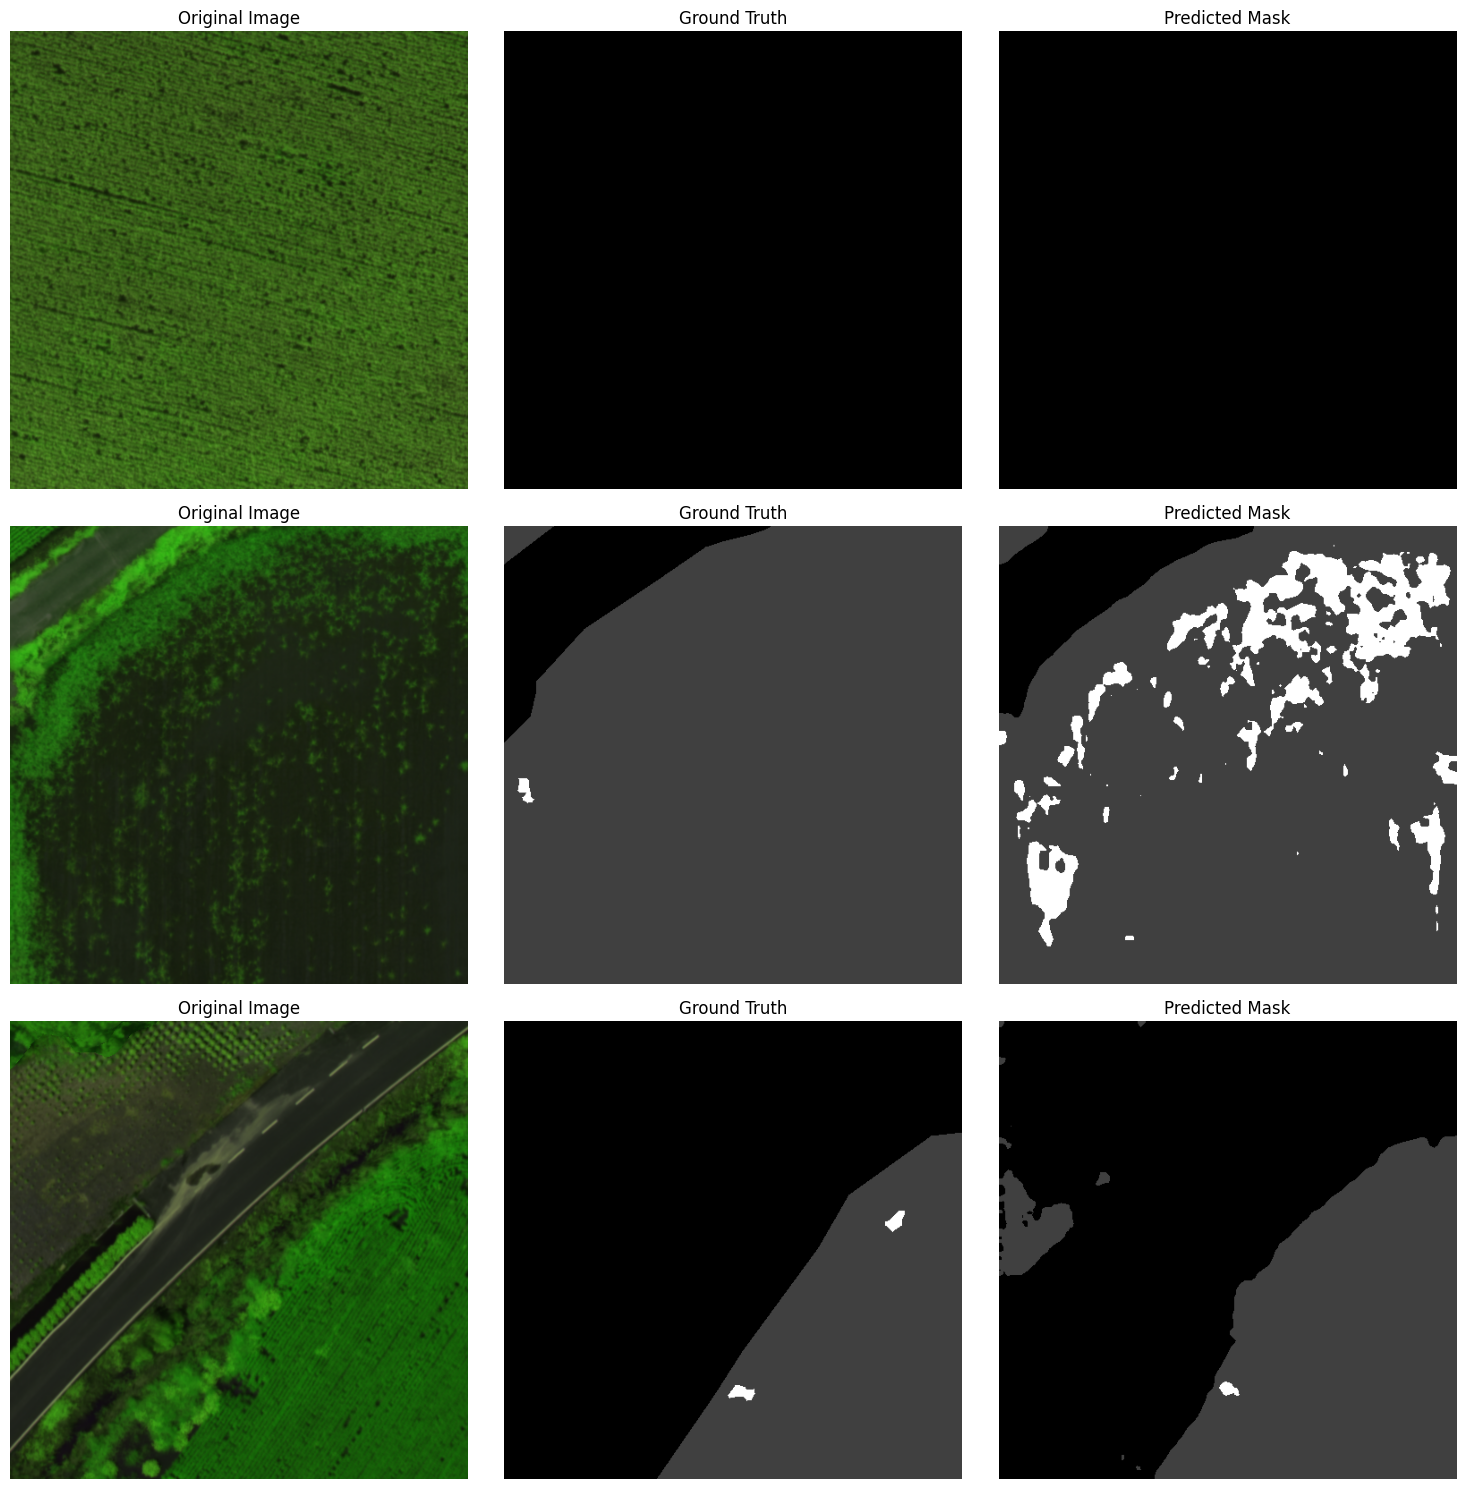

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_images=3):
    model.eval()  # 모델을 평가 모드로 전환
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))  # num_images 행, 3 열의 플롯 생성

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if images_so_far >= num_images:
                break

            pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
            labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동

            with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1).cpu()  # 예측값 계산 후 CPU로 이동

            for j in range(pixel_values.size(0)):
                if images_so_far >= num_images:
                    break

                image = pixel_values[j].cpu().numpy().transpose(1, 2, 0)  # 이미지 형식을 HWC로 변환
                gt_mask = labels[j].cpu().numpy()  # GT 마스크를 numpy 배열로 변환
                pred_mask = predicted[j].numpy()  # 예측 마스크를 numpy 배열로 변환

                # 원본 이미지, GT 마스크, 예측 마스크 시각화
                axes[images_so_far, 0].imshow(image)
                axes[images_so_far, 0].set_title('Original Image')
                axes[images_so_far, 0].axis('off')

                axes[images_so_far, 1].imshow(gt_mask, cmap='gray')
                axes[images_so_far, 1].set_title('Ground Truth')
                axes[images_so_far, 1].axis('off')

                axes[images_so_far, 2].imshow(pred_mask, cmap='gray')
                axes[images_so_far, 2].set_title('Predicted Mask')
                axes[images_so_far, 2].axis('off')

                images_so_far += 1

    plt.tight_layout()
    plt.show()

# 예측 시각화 함수 호출
visualize_predictions(model, val_loader, device)
